# Leopardgecko - AvgPooling3DConsistencyData

## Average pooling of h5 volumetric data that was 'predicted' and combined using the neural network predictor
  
Divide volume in 512x512x512 volumes to be processed with PyTorch's AvgPool3D.
https://pytorch.org/docs/stable/generated/torch.nn.AvgPool3d.html

(Arrays may need to be converted from hdf5 to numpy before passing to pytorch.)  

Stores resulting averaging in another (smaller) array. Also keep track of the X,Y,Z coordinate indexes on the original data corresponding to each element in this average volume calculation.

Data is saved in a hdf5 with filename added suffix "\_VolAvg_k\<k_width\>\_s\<s_stride\>"

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import dask.array as da
import h5py
import os

#For showing nested loop progress
from IPython.display import clear_output
import math

In [2]:
# Pytorch helping functions to do the Average pooling using GPU if possible
def AvgPool3DPytorchGPU(data3d_np , kwidth=8 , stride0=1):

    assert torch.cuda.is_available(), "CUDA not available, terminating..."
    
    #convert to torch objects, and to gpu using cuda()
    data3d_torch = torch.unsqueeze( torch.unsqueeze( torch.from_numpy(data3d_np),0),0 ).cuda()
    
    #setup torch calculation
    torchc3d = torch.nn.AvgPool3d(kwidth, stride0)
    
    result = torchc3d(data3d_torch)
    
    return result.cpu().detach().numpy()[0][0]

def AvgPool3DPytorch(data3d_np , kwidth=8 , stride0=1):
    #Generic. It will use the GPU if available
    if torch.cuda.is_available():
            dev="cuda:0"
    else:
            dev="cpu"
    device = torch.device(dev)
    
    #convert to torch objects, and to gpu using cuda()
    data3d_torch = torch.unsqueeze( torch.unsqueeze( torch.from_numpy(data3d_np),0),0 ).to(device)
    
    #setup torch calculation
    torchc3d = torch.nn.AvgPool3d(kwidth, stride0)
    
    #Run the calculation
    result = torchc3d(data3d_torch)
    
    return result.cpu().detach().numpy()[0][0]

In [3]:
def show_halfwayZslice(data3d):
    plt.imshow( data3d[ int(data3d.shape[0]/2), :, : ] )
    print("shape:" , data3d.shape, "slice:", int(data3d.shape[0]/2))

In [4]:
def ConsistencyWeightData_AutoMaxMin(largedata_da):
    print("Determining vmax and vmin")
    #Created weighted data, weighting it with a square function
    vmax = da.max(datahdf5_as_daskArray).compute()
    vmin = da.min(datahdf5_as_daskArray).compute()
    print("vmax: " , vmax , "  vmin: " , vmin)
    vaverage = 0.5*(vmax-vmin)
    data_da_weighted = da.square(datahdf5_as_daskArray - vaverage) #weighting values
    print ("data_da_weighted.shape = ", data_da_weighted.shape)
    return data_da_weighted

In [5]:
def GetVolAverageCornerAt(data_da_weighted, iz,iy,ix , w_avg , k_width, s_stride ):
    #Check all is ok
    assert ( iz >=0 and iy>=0 and ix>=0 ) , "Error, indexes cannot be < 0 ."
    
    assert ( iz < data_da_weighted.shape[0] and
            iy < data_da_weighted.shape[1] and
            ix < data_da_weighted.shape[2]) , "Error, invlaid indexes."
    
    #Adjust limits
    iz_da_min = iz
    iz_da_max = iz_da_min + w_avg
    if iz_da_max > data_da_weighted.shape[0] :
        iz_da_max = data_da_weighted.shape[0]
        iz_da_min = iz_da_max- w_avg
    
    iy_da_min = iy
    iy_da_max = iy_da_min + w_avg
    if iy_da_max > data_da_weighted.shape[1] :
        iy_da_max = data_da_weighted.shape[1]
        iy_da_min = iy_da_max- w_avg
    
    ix_da_min = ix
    ix_da_max = ix_da_min + w_avg
    if ix_da_max > data_da_weighted.shape[2] :
        ix_da_max = data_da_weighted.shape[2]
        ix_da_min = ix_da_max- w_avg
    
    print( "iz_da_min=", iz_da_min,", iz_da_max=", iz_da_max,
          ", iy_da_min=", iy_da_min,", iy_da_max=", iy_da_max,
          ", ix_da_min=", ix_da_min,", ix_da_max=", ix_da_max
         )
    
    #Get volume and convert to numpy array
    datavol_da = data_da_weighted [ iz_da_min:iz_da_max , iy_da_min:iy_da_max , ix_da_min:ix_da_max ]

    #print("datavol_da.shape = ", datavol_da.shape)
    #convert to numpy
    datavol_np = datavol_da.compute()
    #print("datavol_np.shape = ", datavol_np.shape)

    #Calculate here the AvgPooling (big calculation)
    datavol_avg = AvgPool3DPytorchGPU(datavol_np , k_width , s_stride )

    print ("AvgPool3D calculation complete")
    print("datavol_avg.shape = ",datavol_avg.shape)
    
    torch.cuda.empty_cache()
    
    return datavol_avg, (iz_da_min , iz_da_max , iy_da_min , iy_da_max , ix_da_min , ix_da_max)

In [6]:
def AvgPool3D_LargeData(largedata_da , w_avg = 512, k_width=256 , s_stride=8 , do_weighting = True):
    #This function will do the avarage pooling in 3D using PyTorch AvgPool3D
    #It splits data into chunks automatically
    #and then combines the data automaticaly
    #It returns the average for each point.
    
    assert (w_avg > k_width), "w_avg (window width average) should be higher than kwidth"
    
    if (do_weighting):
        data_da_weighted = ConsistencyWeightData_AutoMaxMin(largedata_da)
    else:
        data_da_weighted = largedata_da
    
    
    result_avg_of_vols = np.zeros( ( int( (data_da_weighted.shape[0]-k_width)/s_stride )+1 , 
                           int( (data_da_weighted.shape[1]-k_width)/s_stride )+1  ,
                           int( (data_da_weighted.shape[2]-k_width)/s_stride )+1  ))

    print ("result_avg_of_vols.shape = " , result_avg_of_vols.shape)
    
    # BIG CALCULATION
    
    #Nested iterations of w_avg x w_avg x w_avg volumes
    #step0 = int( (w_avg - k_width) / s_stride )
    step0 = int(w_avg - k_width)
    
    niter = 0 #Count the number of ierations
    time0 = time.perf_counter()
    time1 = time0
    
    ntotaliter = int(data_da_weighted.shape[0]/step0) * int(data_da_weighted.shape[1]/step0)* int(data_da_weighted.shape[2]/step0)
    
    print ("ntotaliter  = ", ntotaliter)
    
    time.sleep(2) #A little pause to see print output
    
    for iz_da in range(0 , data_da_weighted.shape[0] , step0):
        for iy_da in range(0 , data_da_weighted.shape[1] , step0):
            for ix_da in range(0 , data_da_weighted.shape[2] , step0):
            
                #Show progress
                #clear_output(wait=True)
                
                if (niter>0):
                    print("niteration = ", niter , "/", ntotaliter)
                    print ("Estimated time to finish (s) = ",
                           str( round( (ntotaliter-niter)*(time1-time0)/niter) ) )
                
                print("iz_da=", iz_da , "/" , data_da_weighted.shape[0] ,
                      " , iy_da=", iy_da , "/" , data_da_weighted.shape[1] ,
                      " , ix_da=", ix_da , "/" , data_da_weighted.shape[2]
                     )

                datavol_avg , index_limits = GetVolAverageCornerAt(data_da_weighted, iz_da,iy_da,ix_da , w_avg , k_width, s_stride )
                
                clear_output(wait=True)
                
                time1 = time.perf_counter()
                niter += 1
                
                #With data collected, store it in appropriate array 
                print("index_limits = ", index_limits)
                iz = int(index_limits[0] / s_stride)
                iy = int(index_limits[2] / s_stride)
                ix = int(index_limits[4] / s_stride)

                print ("Start indexes to store at result_avg_of_vols: " , iz , iy , ix)

                result_avg_of_vols[ iz : (iz + datavol_avg.shape[0]) ,
                                  iy : (iy + datavol_avg.shape[1]) ,
                                  ix : (ix + datavol_avg.shape[2]) ] = datavol_avg

    print("Completed.")      
    
    
    #Create the respective indexes
    result_avg_of_vols_x_range = np.arange( int(k_width/2) , data_da_weighted.shape[2]-int(k_width/2)+1, s_stride )
    result_avg_of_vols_y_range = np.arange( int(k_width/2) , data_da_weighted.shape[1]-int(k_width/2)+1 , s_stride )
    result_avg_of_vols_z_range = np.arange( int(k_width/2) , data_da_weighted.shape[0]-int(k_width/2)+1 , s_stride )

    #Attention, order of x,y,z has to be in this way
    #otherwise the vales will not correspond to the averaging point volumes.
    #In a 3D array, first index is zz, 2nd is yy, and 3rd is xx
    result_avg_of_vols_z , result_avg_of_vols_y , result_avg_of_vols_x = np.meshgrid( result_avg_of_vols_z_range ,
                                                                                    result_avg_of_vols_y_range,
                                                                                    result_avg_of_vols_x_range,
                                                                                    indexing='ij')
    #Resulting meshgrids should have the same shape as result_avg_of_vols
    print ("result_avg_of_vols_x.shape = ", result_avg_of_vols_x.shape )
    
    #TODO Return the averaged data and the X , Y and Z indices
    return result_avg_of_vols , result_avg_of_vols_z , result_avg_of_vols_y , result_avg_of_vols_x

In [7]:
# Input filename
# Change as appropriate
# The location of the file is for LMAP VM in Guacamole
data_filename = '/workspace/for_luis/2020-04-09_final_4_volumes_combined.h5'

In [8]:
#Opens file
fx= h5py.File(data_filename,'r')
datahdf5_as_daskArray = da.from_array(fx['data'], chunks='auto')

In [9]:
#Do the averaging (long)
#For testing, change stride to higher values, such as 32 or 64
w_avg = 512
k_width = 256
s_stride= 128
result_avg_of_vols_tuple = AvgPool3D_LargeData(datahdf5_as_daskArray , w_avg, k_width , s_stride, do_weighting = True)

index_limits =  (1608, 2120, 2008, 2520, 2008, 2520)
Start indexes to store at result_avg_of_vols:  12 15 15
Completed.
result_avg_of_vols_x.shape =  (15, 18, 18)


In [10]:
#unpack result
(result_avg_of_vols , result_avg_of_vols_z , result_avg_of_vols_y, result_avg_of_vols_x) = result_avg_of_vols_tuple

shape: (15, 18, 18) slice: 7


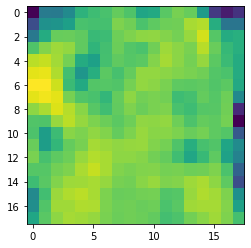

In [11]:
# Quick check of result
show_halfwayZslice(result_avg_of_vols)

In [12]:
#Test
#os.path.split('/workspace/for_luis/2020-04-09_final_4_volumes_combined.h5')

In [13]:
#Test
#os.path.splitext('2020-04-09_final_4_volumes_combined.h5')

In [14]:
#Save file (locally, at the same folder as this notebook)
pathhead, pathtail = os.path.split(data_filename)
pathname , ext = os.path.splitext(pathtail)
newpathname = pathname + "_VolAvg_k" + str(k_width)+"_s"+str(s_stride)
newfilename = newpathname + '.h5'
print (newfilename)

with h5py.File(newfilename ,'w') as f:
    f['/data']= result_avg_of_vols
    f['/Z']= result_avg_of_vols_z
    f['/Y']= result_avg_of_vols_y
    f['/X']= result_avg_of_vols_x

2020-04-09_final_4_volumes_combined_VolAvg_k256_s128.h5
